In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd 
from selenium import webdriver
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np
from dotenv import load_dotenv
from langchain import HuggingFaceHub
from langchain import PromptTemplate
from langchain.chains import LLMChain
import smtplib

load_dotenv()

True

In [2]:

s = int(datetime.today().timestamp())

url = f'https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2={s}&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'

driver = webdriver.Chrome() 

driver.get(url)
driver.implicitly_wait(10)

for _ in range(400):
    driver.execute_script("window.scrollBy(0, 500);")

content = driver.page_source

driver.quit()



In [3]:
soup = BeautifulSoup(content, 'html.parser')


table = soup.find('table', {'data-test': 'historical-prices'})

df = pd.read_html(str(table))[0]
df = df.drop(df.index[-1])



print(df.shape)

C:\Users\teani\AppData\Local\Temp\ipykernel_8584\2200980255.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


(3427, 7)


In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
df['Date'] = pd.to_datetime(df['Date'], "%b %d, %Y")
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close*'] = df['Close*'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

df['Close'] = df['Close*'].astype(float)

df = df.drop(columns = ['Adj Close**', 'Close*'])
df = df.head(3400)



<Axes: xlabel='Date'>

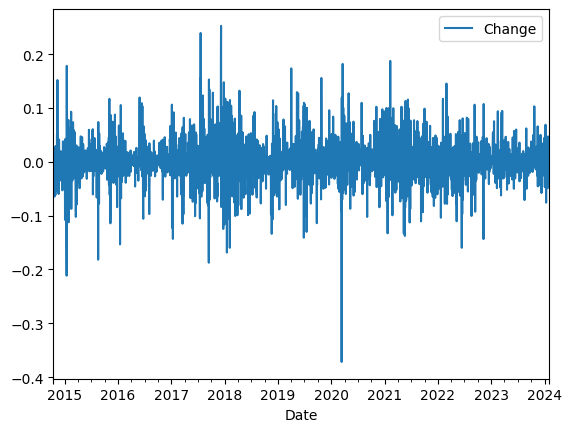

In [5]:
df["Change"] = df["Close"].pct_change(periods=-1)  #procentualna promena 
df.drop(df.tail(1).index,inplace=True)

df.plot(x = 'Date',y = 'Change')


<Axes: xlabel='Date'>

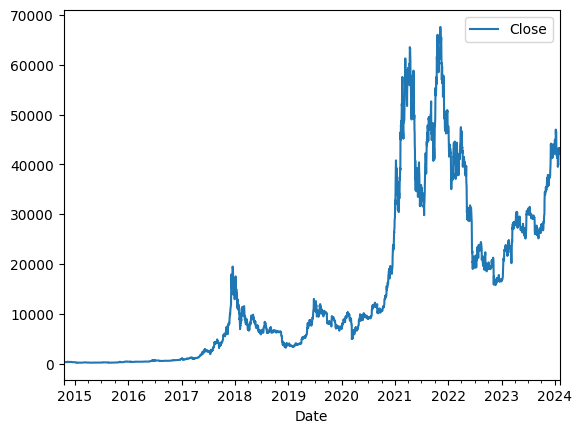

In [6]:
df.plot(x = 'Date', y = 'Close')

In [7]:
train_len = int(0.8 * len(df))
test_len = len(df) - train_len

train = (df.tail(train_len)).copy()
test = (df.head(test_len)).copy()

train = train.sort_values("Date").reset_index()
test = test.sort_values("Date").reset_index()

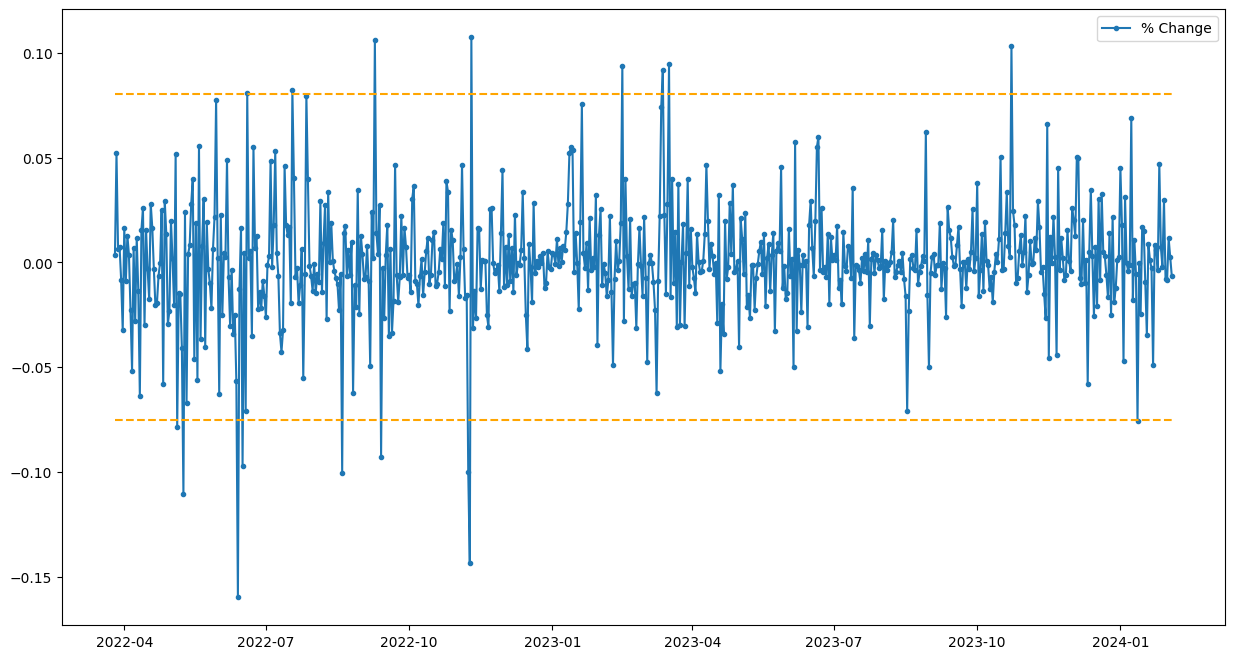

In [8]:
mean = train["Change"].mean()
std = train["Change"].std()

test["Upper"] = mean + 2*std
test["Lower"] = mean - 2*std

plt.figure(figsize=(15, 8))

plt.plot(test["Date"], test["Change"], label="% Change", marker=".")
plt.plot(test["Date"], test["Upper"], linestyle="--", color="orange")
plt.plot(test["Date"], test["Lower"], linestyle="--", color="orange")
plt.legend()


In [ ]:
auto_arima = pm.auto_arima(train["Change"], trace=True, stepwise=False, seasonal=False)
auto_arima.summary()

In [10]:
best_order = auto_arima.get_params().get("order")

In [ ]:
history = [x for x in train["Change"]]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test["Change"][t]
    history.append(obs)


In [12]:
print("Predicted BTC Price Change for Tomorrow:", predictions[-1])


Predicted BTC Price Change for Tomorrow: 0.0022356973653845464


In [13]:

y_true = test["Change"]
y_pred = predictions

squared_diff = (y_true - y_pred) ** 2

mean_squared_diff = np.mean(squared_diff)

rmse = np.sqrt(mean_squared_diff)

rmse


0.027603207128551778

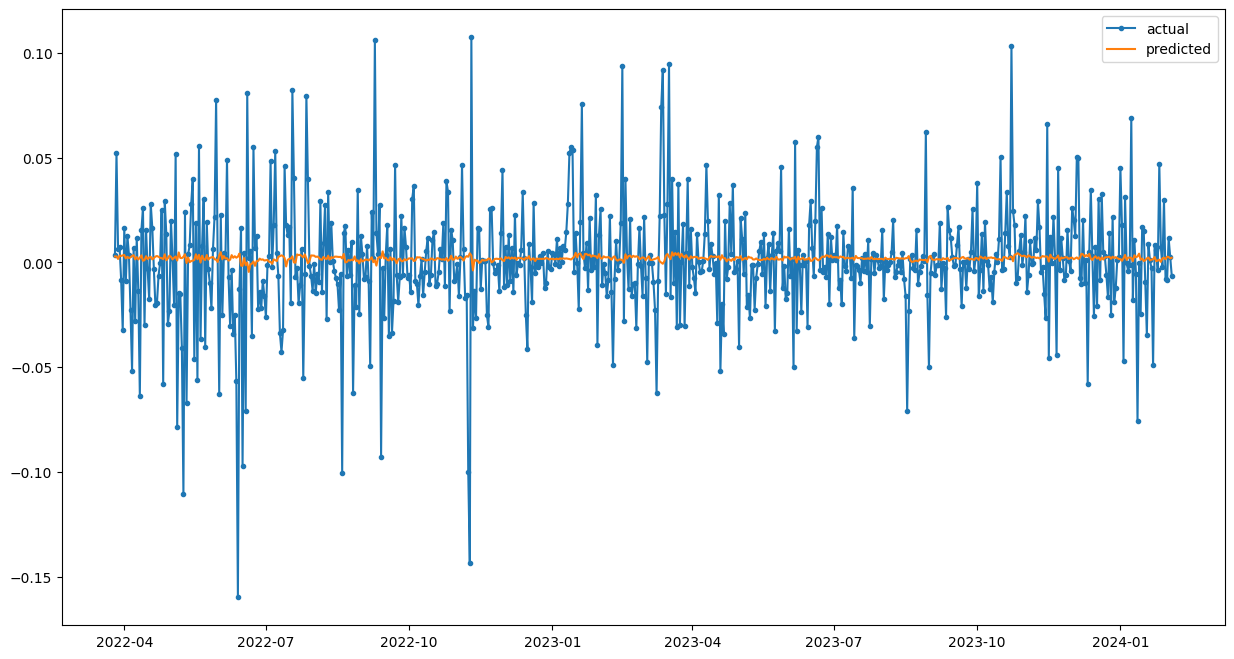

In [14]:
plt.figure(figsize=(15, 8))

plt.plot(test["Date"], test["Change"], label="actual", marker=".")
plt.plot(test["Date"], predictions, label="predicted")
plt.legend()


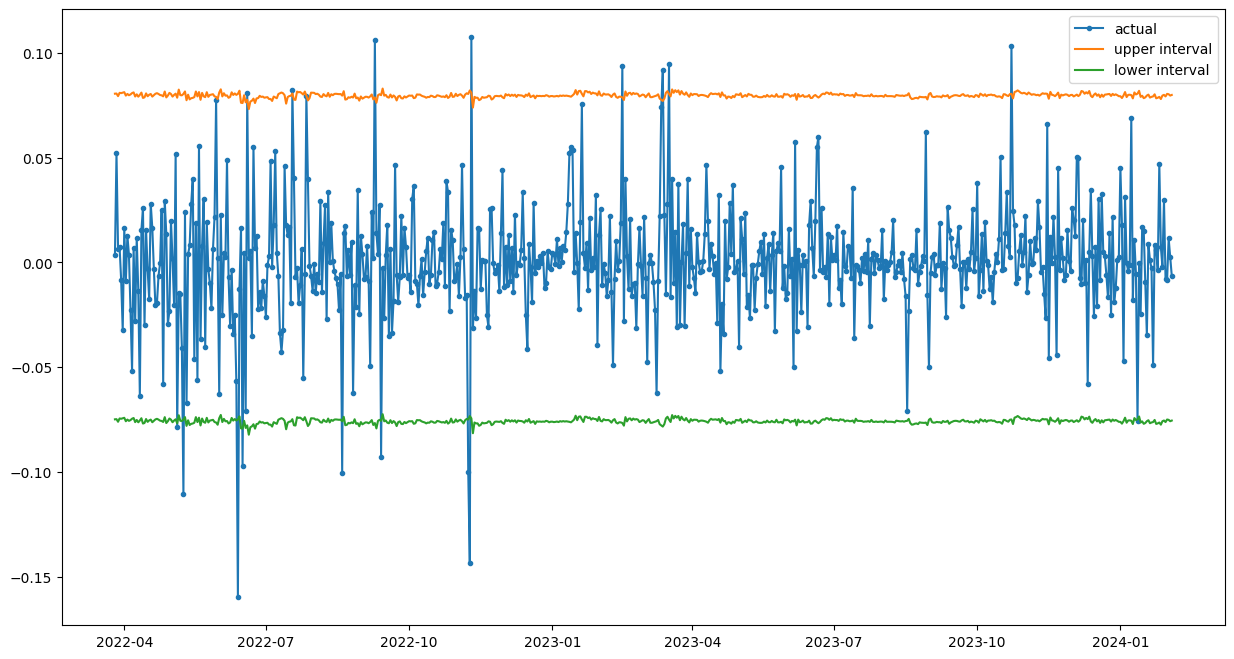

In [15]:
plt.figure(figsize=(15, 8))

plt.plot(test["Date"], test["Change"], label="actual", marker=".")
plt.plot(test["Date"], predictions + 2*std, label="upper interval")
plt.plot(test["Date"], predictions - 2*std, label="lower interval")
plt.legend()


LLM

In [ ]:
conv_model = HuggingFaceHub(repo_id='tiiuae/falcon-7b-instruct', model_kwargs={"max_new_tokens": 5000})

In [17]:
template = '''You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The opposite, the users should be 
informed to withdraw money. 

{query}
'''

prompt = PromptTemplate(template = template, input_variables=['query'])

In [18]:
conv_chain = LLMChain(llm = conv_model, 
                      prompt = prompt,
                      verbose = True)

In [19]:
btc_price = df['Close'].iloc[0]
change = predictions[-1]
message = conv_chain.run(f'Bitcoin price - {btc_price}, expected change - {change}%')

print(conv_chain.run(f'Bitcoin price - {btc_price}, expected change - {change}%'))

c:\Users\teani\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:
You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The opposite, the users should be 
informed to withdraw money. 

Bitcoin price - 42913.09, expected change - 0.0022356973653845464%


> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:
You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The opposite, the users should be 
informed to withdraw money. 

Bitcoin price - 42913.09, expected change - 0.0022356973653845464%


> Finished chain.
You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The

In [20]:
start_index = message.find("We hope this email")
# Extract the substring starting from the response

extracted_response = message[start_index:]
print(extracted_response)

We hope this email finds you well. We wanted to inform you about the current price of Bitcoin, which is currently trading at $42913.09. Our experts predict a minimal change in the price within the next 24 hours. Therefore, we advise users to consider investing in Bitcoin at this moment.

On the other hand, if the expected change is in a positive direction, users should consider withdrawing their funds to avoid potential losses.

Thank


EMAIL

In [21]:
sender = 'btcnotification036@gmail.com'
recivers = ['tea.nikolic525@gmail.com']
message = f"""From: BTC Notification from Gmail <btcnotification036@gmail.com>
To: Teodora Nikolic {recivers[0]}
Subject: Bitcoin notification

{extracted_response}


"""


smtpObj = smtplib.SMTP('smtp.gmail.com', 587)
smtpObj.starttls() 
smtpObj.login(sender,'whdp xlyo zfux poxh')  

smtpObj.sendmail(sender, recivers, message)        
print("Successfully sent email")

Successfully sent email
